# Performing Person Detection on the TF-Lite Models

In [ ]:
# Importing necessary packages
import tensorflow as tf
import numpy as np
import importlib.util
from google.colab.patches import cv2_imshow
import cv2
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from scipy import ndimage

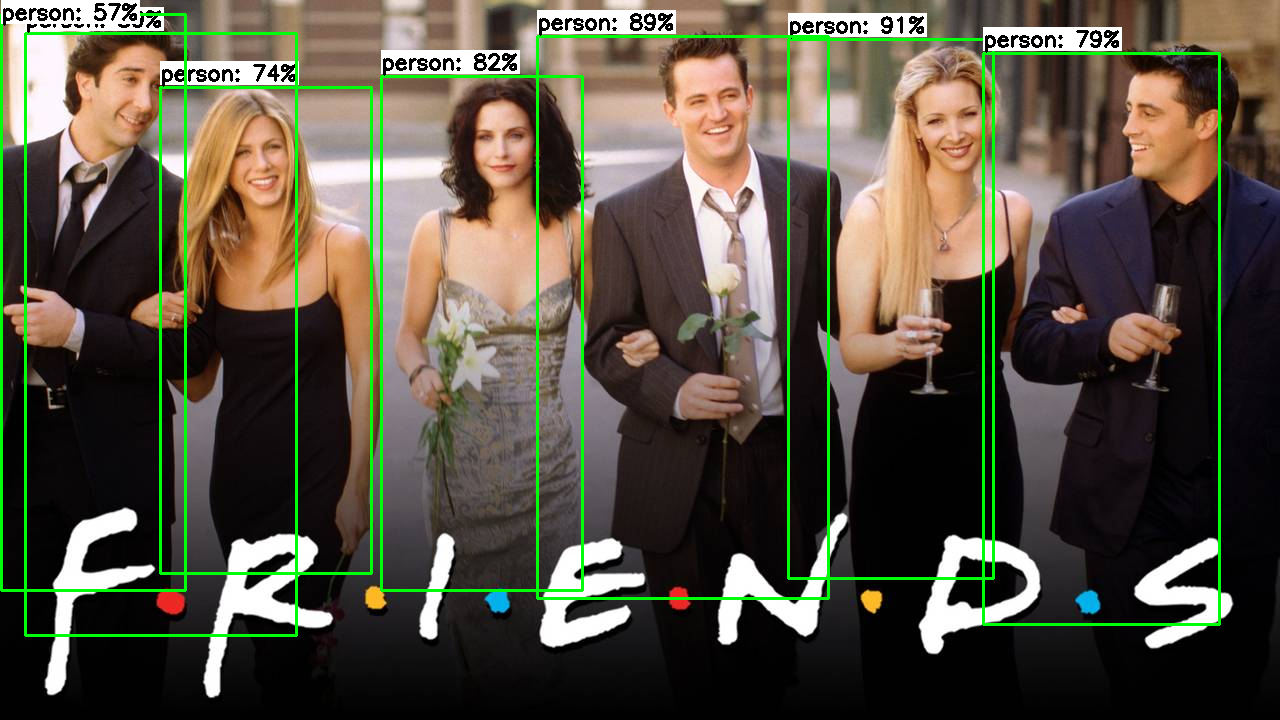

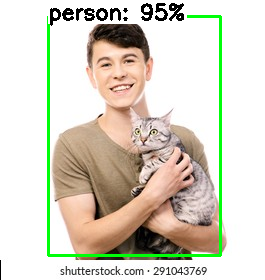

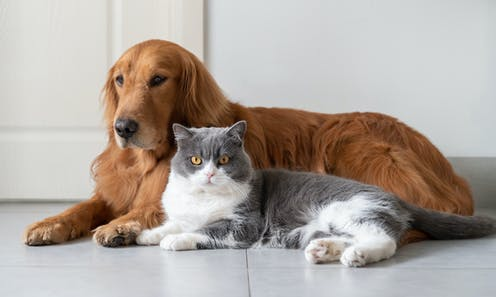

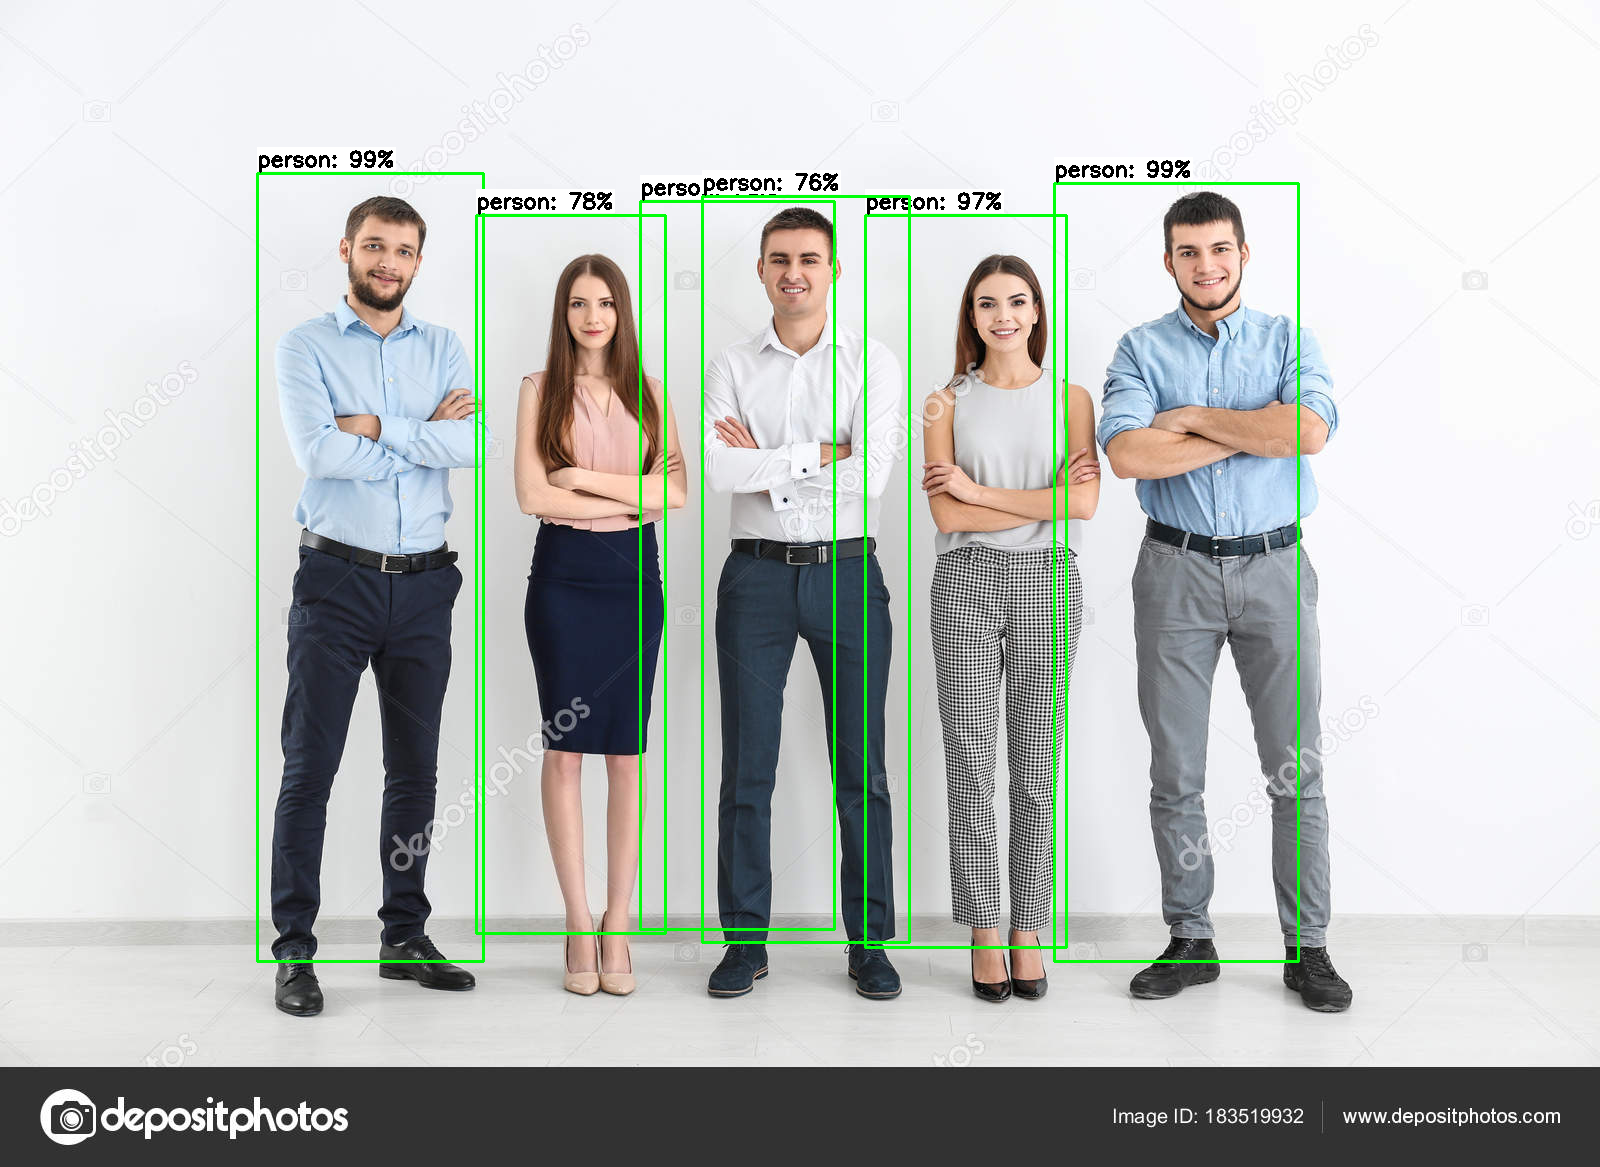

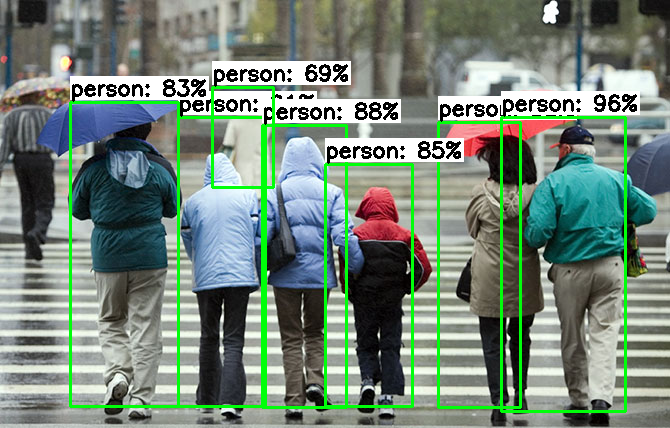

In [ ]:
# Passing the integer-only quantised TF-Lite model
interpreter = tf.lite.Interpreter("tflite_quant_model_int.tflite") 
#Allocates memory for the model's input Tensors
interpreter.allocate_tensors() 

# Get model details
input_details = interpreter.get_input_details() 
output_details = interpreter.get_output_details()

# Getting height & width  -- 300x300 since our model was trained on 300x300 images
height = input_details[0]['shape'][1]  
width = input_details[0]['shape'][2]   

 # Boolean operation to check if model is float or int
floating_model = (input_details[0]['dtype'] == np.float32)
uint8_model = (input_details[0]['dtype'] == np.uint8)

# Uploading the labels & storing in a list
with open("labels.txt", 'r') as f:
  labels = [line.strip() for line in f.readlines()]

# Parameter values of the input image in MobileNet 
input_mean = 127.5 
input_std = 127.5

# Specifying a minimum confidence threshold
min_conf_threshold = 0.55

# Passing our test images 
images = ["friends.jpg", "mh.jpg", "catdog.jpg", "people.jpg", "crosswalk.jpg"]

# Loop over every image and perform detection
for image_path in images:
    # Load image and resize to expected shape 
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imH, imW, _ = image.shape 
    image_resized = cv2.resize(image_rgb, (width, height))
    input_data = np.expand_dims(image_resized, axis=0)

    # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
    if floating_model:
      input_data = (np.float32(input_data) - input_mean) / input_std
     
    # Perform the actual detection by running the model with the image as input
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()


    # Retrieve detection results
    # Bounding box coordinates of detected objects
    boxes = interpreter.get_tensor(output_details[0]['index'])[0] 
    # Class index of detected objects
    classes = interpreter.get_tensor(output_details[1]['index'])[0] 
    # Confidence of detected objects
    scores = interpreter.get_tensor(output_details[2]['index'])[0] 

    # IF UINT8 MODEL: Obtaining true value from int_8 value 
    # real_value = (int8_value - zero_point)*scale
    if uint8_model:
      # Getting the scale from the model's input details
      scale = interpreter.get_input_details()[0]["quantization"][0] 
      # Getting the zero point from the model's input details
      zero_point = interpreter.get_input_details()[0]["quantization"][1] 
      # Scaling the values correspondingly
      boxes = boxes*scale 
      scores = scores*scale
      classes = classes*scale

    # Loop over all detections and draw detection box if confidence is above minimum threshold
    for i in range(len(scores)):
      # If anything other than a human is detected --> score is set to 0
        if classes[i] != 0:
          scores[i] = 0
        if (scores[i] > min_conf_threshold): # Only considering detections above threshold confidence

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions
            # Forcing them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))
            
            # Drawing the rectangular box
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2) 

            # Draw label
            # Look up object name from "labels" array using class index
            object_name = labels[int(classes[i])] 
            # Example: 'person: 72%'
            label = '%s: %d%%' % (object_name, (scores[i])*100) 
            # Get font size
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) 
            # Make sure not to draw label too close to top of window
            label_ymin = max(ymin, labelSize[1] + 10) 
            # Draw white box to put label text in
            cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED)             
            cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

    cv2_imshow(image)